# Variant effect prediction

In [1]:
import os

import numpy as np
import h5py
from keras import backend as K
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from pkg_resources import resource_filename

from janggu import Janggu
from janggu import Scorer
from janggu import inputlayer
from janggu import outputdense
from janggu.data import Bioseq
from janggu.data import Cover
from janggu.data import GenomicIndexer
from janggu.data import ReduceDim
from janggu.data import plotGenomeTrack
from janggu.data import LineTrack
from janggu.data import SeqTrack
from janggu.layers import DnaConv2D
from janggu import input_attribution

np.random.seed(1234)

Using TensorFlow backend.


First, we need to specify the output directory in which the results are stored and load the datasets.

In [4]:
order = 3
epochs = 100

In [5]:
os.environ['JANGGU_OUTPUT'] = '/home/wkopp/janggu_examples'

# load the dataset
# The pseudo genome represents just a concatenation of all sequences
# in sample.fa and sample2.fa. Therefore, the results should be almost
# identically to the models obtained from classify_fasta.py.
REFGENOME = resource_filename('janggu', 'resources/pseudo_genome.fa')
VCFFILE = resource_filename('janggu', 'resources/pseudo_snps.vcf')
# ROI contains regions spanning positive and negative examples
ROI_TRAIN_FILE = resource_filename('janggu', 'resources/roi_train.bed')
ROI_TEST_FILE = resource_filename('janggu', 'resources/roi_test.bed')

# PEAK_FILE only contains positive examples
PEAK_FILE = resource_filename('janggu', 'resources/scores.bed')

In [6]:
# Training input and labels are purely defined genomic coordinates
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   binsize=200,
                                   store_whole_genome=True,
                                   order=order)

LABELS = Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200)


DNA_TEST = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                        roi=ROI_TEST_FILE,
                                        binsize=200,
                                        store_whole_genome=True,
                                        order=order)

LABELS_TEST = Cover.create_from_bed('peaks',
                                    roi=ROI_TEST_FILE,
                                    bedfiles=PEAK_FILE,
                                    binsize=200,
                                    resolution=200)

loading from lazy loader
loading from bed lazy loader
loading from lazy loader
loading from bed lazy loader


Define and fit a now model

In [9]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model_dnaconv(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    A more elegant way of scanning both strands for motif occurrences
    is achieved by the DnaConv2D layer wrapper, which internally
    performs the convolution operation with the normal kernel weights
    and the reverse complemented weights.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        layer = DnaConv2D(Conv2D(params[0], (params[1], 1),
                                 activation=params[2]))(layer)
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output


# create a new model object
model = Janggu.create(template=double_stranded_model_dnaconv,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=ReduceDim(LABELS))

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])

hist = model.fit(DNA, ReduceDim(LABELS), epochs=epochs)

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)

Generated model-id: '485b2e54f83dabde1f86a10f3d7e6c86'
Epoch 1/100
244/244 [==============================] - 17s 70ms/step - loss: 0.6361 - acc: 0.6444
Epoch 2/100
244/244 [==============================] - 16s 67ms/step - loss: 0.5326 - acc: 0.7618
Epoch 3/100
244/244 [==============================] - 17s 68ms/step - loss: 0.4752 - acc: 0.7916
Epoch 4/100
244/244 [==============================] - 16s 67ms/step - loss: 0.4340 - acc: 0.8155
Epoch 5/100
244/244 [==============================] - 17s 69ms/step - loss: 0.4050 - acc: 0.8255
Epoch 6/100
244/244 [==============================] - 16s 67ms/step - loss: 0.3812 - acc: 0.8372
Epoch 7/100
244/244 [==============================] - 17s 68ms/step - loss: 0.3607 - acc: 0.8480
Epoch 8/100
244/244 [==============================] - 17s 71ms/step - loss: 0.3392 - acc: 0.8600
Epoch 9/100
244/244 [==============================] - 18s 72ms/step - loss: 0.3181 - acc: 0.8722
Epoch 10/100
244/244 [==============================] - 17s 70m

244/244 [==============================] - 8s 34ms/step - loss: 0.0199 - acc: 0.9983
Epoch 84/100
244/244 [==============================] - 8s 34ms/step - loss: 0.0200 - acc: 0.9983
Epoch 85/100
244/244 [==============================] - 8s 34ms/step - loss: 0.0194 - acc: 0.9982
Epoch 86/100
244/244 [==============================] - 8s 34ms/step - loss: 0.0188 - acc: 0.9986
Epoch 87/100
244/244 [==============================] - 8s 34ms/step - loss: 0.0184 - acc: 0.9983
Epoch 88/100
244/244 [==============================] - 8s 34ms/step - loss: 0.0182 - acc: 0.9988
Epoch 89/100
244/244 [==============================] - 8s 34ms/step - loss: 0.0175 - acc: 0.9987
Epoch 90/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0169 - acc: 0.9988
Epoch 91/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0166 - acc: 0.9994
Epoch 92/100
244/244 [==============================] - 15s 60ms/step - loss: 0.0165 - acc: 0.9987
Epoch 93/100
244/244 [==========

In [10]:
pred = model.predict(DNA_TEST)
cov_pred = Cover.create_from_array('BindingProba', pred, LABELS_TEST.gindexer)

print('Oct4 predictions scores should be greater than Mafk scores:')
print('Prediction score examples for Oct4')
for i in range(4):
    print('{}.: {}'.format(i, cov_pred[i]))
print('Prediction score examples for Mafk')
for i in range(1, 5):
    print('{}.: {}'.format(i, cov_pred[-i]))

Oct4 predictions scores should be greater than Mafk scores:
Prediction score examples for Oct4
0.: [[[[0.99954879]]]]
1.: [[[[0.8408764]]]]
2.: [[[[0.99534822]]]]
3.: [[[[0.98228812]]]]
Prediction score examples for Mafk
1.: [[[[0.28670049]]]]
2.: [[[[0.000442]]]]
3.: [[[[0.00052086]]]]
4.: [[[[3.81469727e-06]]]]


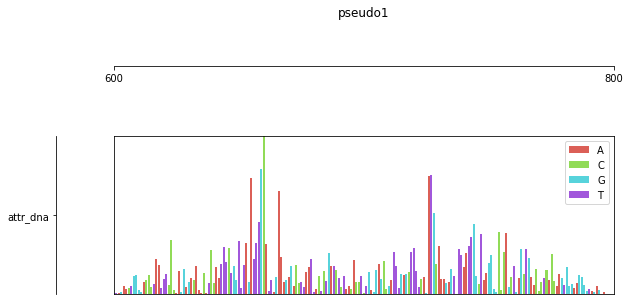

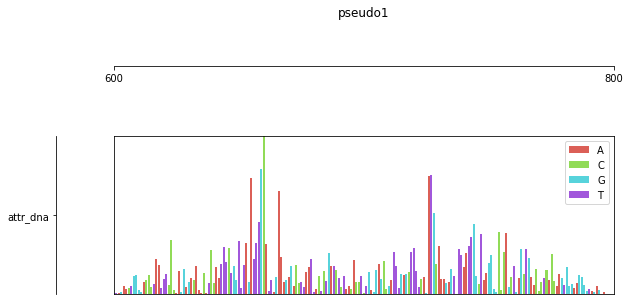

In [12]:
# Extract the 4th interval to perform input feature importance attribution
# which represents an Oct4 bound region
gi = DNA.gindexer[3]
chrom = gi.chrom
start = gi.start
end = gi.end
attr_oct = input_attribution(model, DNA, chrom=chrom, start=start, end=end)

# visualize the important sequence features
plotGenomeTrack(SeqTrack(attr_oct[0]), chrom, start, end)

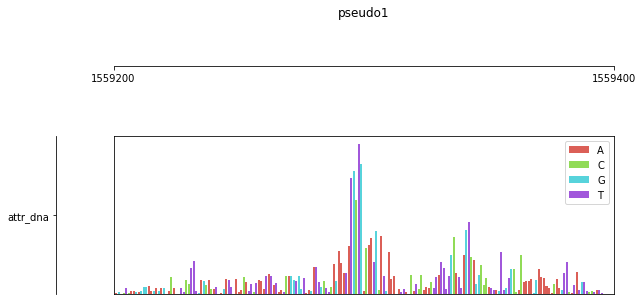

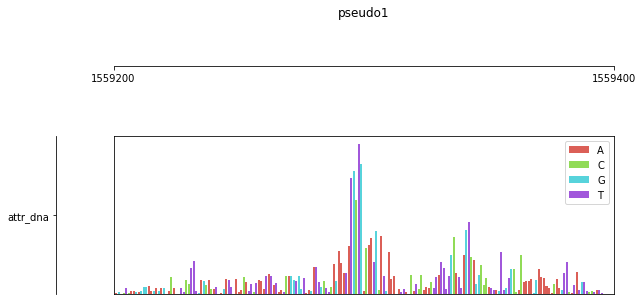

In [13]:
# For the comparison, extract an interval
# representing a Mafk bound region and visualize the
# important features.
gi = DNA.gindexer[7796]
chrom = gi.chrom
start = gi.start
end = gi.end
attr_mafk = input_attribution(model, DNA, chrom=chrom, start=start, end=end)

plotGenomeTrack(SeqTrack(attr_mafk[0]), chrom, start, end)

In [14]:
# output directory for the variant effect prediction
vcfoutput = os.path.join(os.environ['JANGGU_OUTPUT'], 'vcfoutput')
os.makedirs(vcfoutput, exist_ok=True)

# perform variant effect prediction using Bioseq object and
# a VCF file
scoresfile, variantsfile = model.predict_variant_effect(DNA,
                                                        VCFFILE,
                                                        conditions=['feature'],
                                                        output_folder=vcfoutput)

scoresfile = os.path.join(vcfoutput, 'scores.hdf5')
variantsfile = os.path.join(vcfoutput, 'snps.bed.gz')

# parse the variant effect predictions (difference between
# reference and alternative variant) into a Cover object
# for the purpose of visualization
f = h5py.File(scoresfile, 'r')

gindexer = GenomicIndexer.create_from_file(variantsfile, None, None)

snpcov = Cover.create_from_array('snps', f['diffscore'],
                                 gindexer,
                                 store_whole_genome=True,
                                 padding_value=np.nan)
snpcov = Cover.create_from_array('snps', f['diffscore'],
                                 gindexer,
                                 store_whole_genome=False,
                                 padding_value=np.nan)

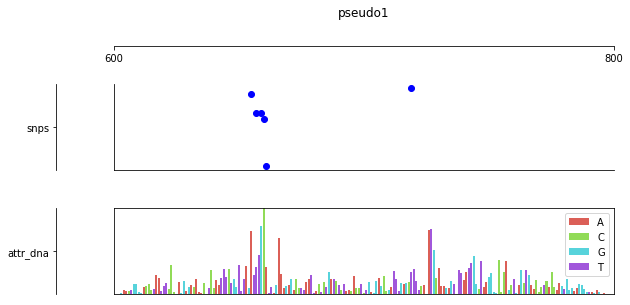

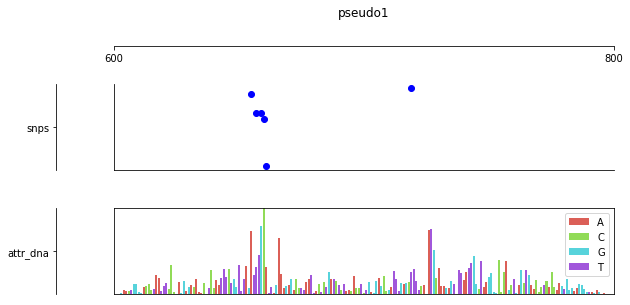

In [15]:
gi = DNA.gindexer[3]
chrom = gi.chrom
start = gi.start
end = gi.end

plotGenomeTrack([LineTrack(snpcov,
                           linestyle="None"), SeqTrack(attr_oct[0])],
                chrom, start, end)